# Estimate Operational Wake Losses based on SCADA Data

In [1]:
%load_ext autoreload
%autoreload 2

This notebook demonstrates how to use the Wake Losses method in OpenOA to estimate operational wake losses for the La Haute Borne wind plant based on turbine-level SCADA data. Operational wake losses are estimated at the wind plant level and for each individual wind turbine during the period of record (POR) when data are available as well as for the estimated long-term wind conditions the wind plant will experience based on historical reanalysis wind resource data. 

At a high-level, wake losses are estimated by comparing the actual energy produced by the wind plant (or turbine) to the potential energy that would have been produced without wake losses, which is treated as the average energy produced by the turbines experiencing freestream inflow multiplied by the number of turbines in the wind plant. Note that this method therefore assumes that without wake losses, each turbine would be capable of producing the same power as the freestream wind turbines, which may not be a valid assumption in some cases, such as in complex terrain or when wake effects from neighboring wind plants are present. 

The approach used to estimate wake losses is as follows.

1. First, a representative wind plant-level wind direction is calculated at each time step using the mean value of the wind direction signals for a user-specified set of wind turbines or meteorological (met) towers. Time steps for which any necessary plant-level or turbine-level data are missing are discarded.
2. Next, the set of derated, curtailed, or unavailable turbines (i.e., turbines whose power production is limited not by wake losses but by operating mode) is identified for each time step using power curve outlier detection.
3. For a sequence of wind direction bins, using the representative wind plant-level wind direction, the set of freestream turbines is identified based on whether any other wind turbines are located upstream of a turbine within a user-specified sector of wind directions. The average power production and average wind speed are then calculated for the set of freestream turbines operating normally (i.e., not derated) for each time step.
4. Period-of-record wake losses are then calculated for the wind plant by comparing the potential energy production (calculated as the sum of the mean freestream power production for each time step multiplied by the number of turbines in the wind plant) to the actual energy production (given by the sum of the actual wind power production for each turbine and each time step). However, if specified by the user, the potential power production of the wind plant at each time step is assumed to be limited to the actual power produced by the derated turbines plus the mean power production of the freestream turbines for all other turbines in the wind plant. This same basic procedure is then used to estimate the wake losses for each individual wind turbine.
5. Lastly, the long-term corrected wake losses are estimated using historical reanalysis data. The long-term frequencies of occurence are calculated for a set of wind direction and wind speed bins, based on historical hourly reanalysis data. Using the representative wind plant wind directions from SCADA or met tower data and the freestream wind speeds based on the turbine SCADA data, the average potential and actual wind plant power production are computed for each wind direction and wind speed bin. The long-term corrected wake losses are then estimated by comparing the long-term corrected potential and actual energy production, which are in turn determined by weighting the average potential and actual power production in each wind condition bin by the long-term frequencies. This basic process is then repeated to estimate the long-term corrected wake losses for each individual turbine.

If uncertainty quantification (UQ) is selected, wake losses are calculated multiple times using a Monte Carlo approach using randomly chosen analysis parameters and reanalysis products as well as randomly sampled time steps each iteration. If UQ is not used, wake losses are calculated using the specified analysis parameters for the full set of available time steps once for each reanalysis product.

In this example, we will demonstrate wake loss analysis both with and without UQ.

In [2]:
# Import required packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()

from openoa.analysis.wake_losses import WakeLosses
from openoa import PlantData
from openoa.utils import met_data_processing as met
from openoa.utils import plot

import project_ENGIE

%matplotlib inline

Loading BokehJS ...

## Import the data

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load PlantData object and validate for the wake losses analysis type
project = project_ENGIE.prepare("data/la_haute_borne")
project.analysis_type.append("WakeLosses")
project.validate()

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data
/Users/esimley/opt/anaconda3/envs/oa-env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


Next, we'll plot the wind plant layout to understand for which wind directions we can expect wake losses. Based on the layout, significant wake losses are expected when the wind is from the northwest to north and southeast to south because some wind turbines will be located in the wake of other turbines for these directions. 

In [4]:
show(plot.plot_windfarm(project.asset,tile_name="OpenMap",plot_width=600,plot_height=600))

## Investigate and correct wind direction data

The wake loss analysis method requires reliable wind direction data from the turbine SCADA or met tower data types to determine the representative wind plant-level wind direction at each time step. Here, we'll investigate the wind direction signals for each wind turbine, determine which turbines have wind direction signals that are reliable enough to use in the analysis, and apply any corrections needed.

In [5]:
# Modify the SCADA data frame so we can access columns using the (variable, turbine ID) 
# pair as the column name
scada_df = project.scada.unstack()

### Identify changes in wind direction northing offset for each turbine 

First, we'll plot the difference between the wind direction signals for each turbine pair to understand if either of the turbines experience changes in their northing offset during the two-year period of record.

The northing offset is defined as the wind direction bias relative to true north. If the average difference between the wind direction measured by a turbine and the true wind direction at the turbine is zero, the northing offset is also zero. A northing offset of 10 degrees means that the measured wind direction is 10 degrees greater than the true wind direction at the turbine location, on average.

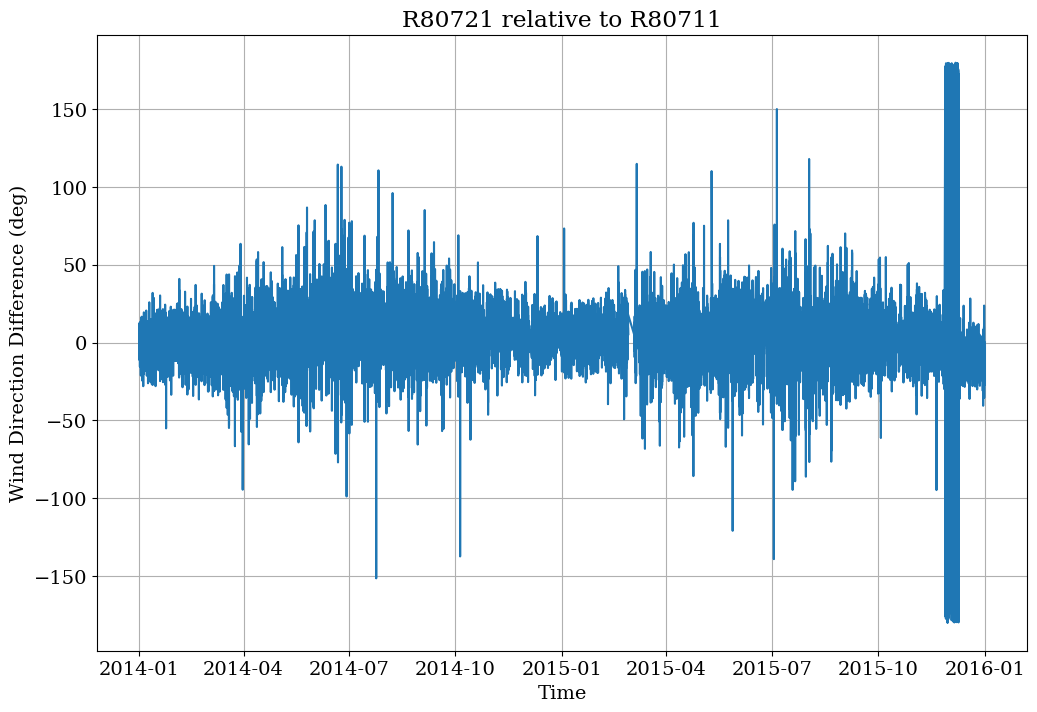

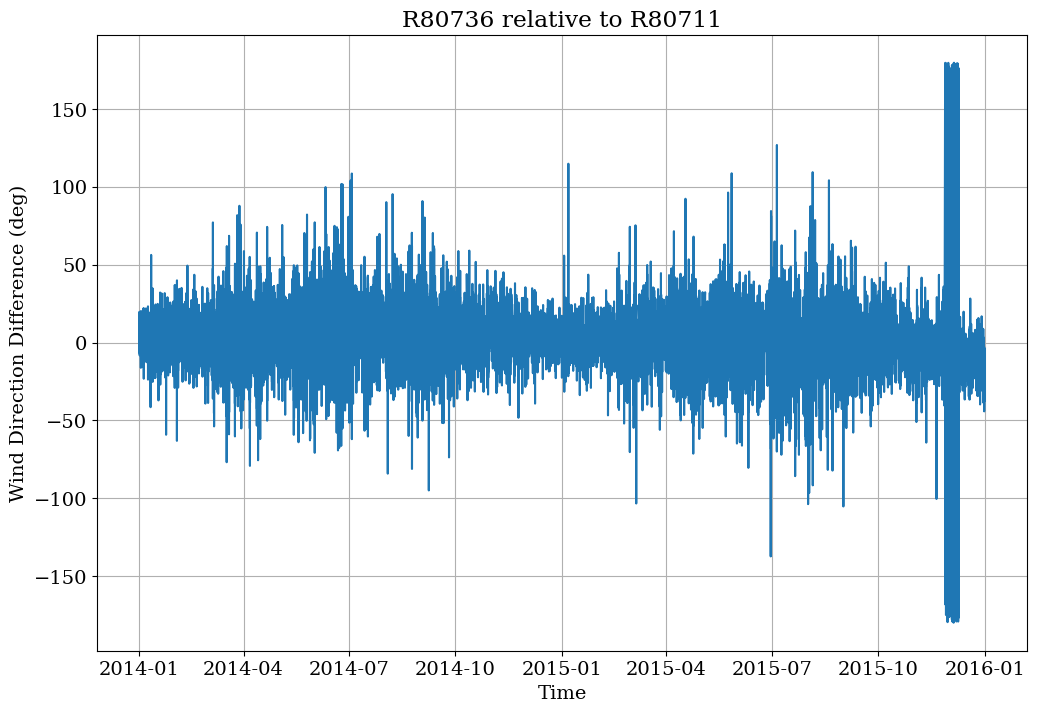

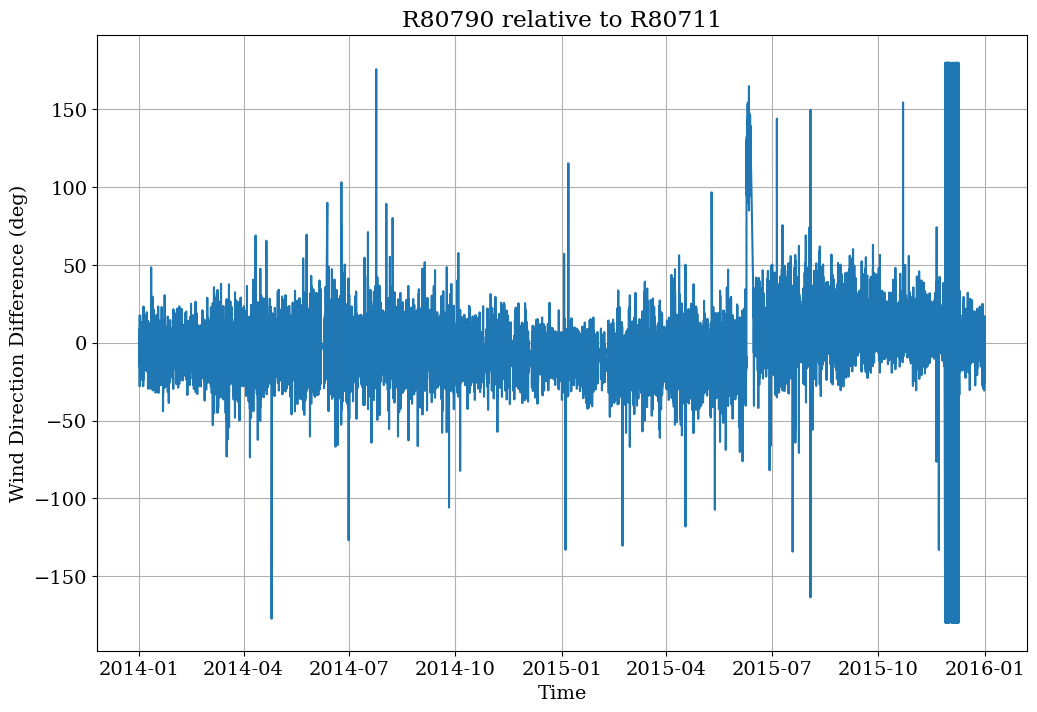

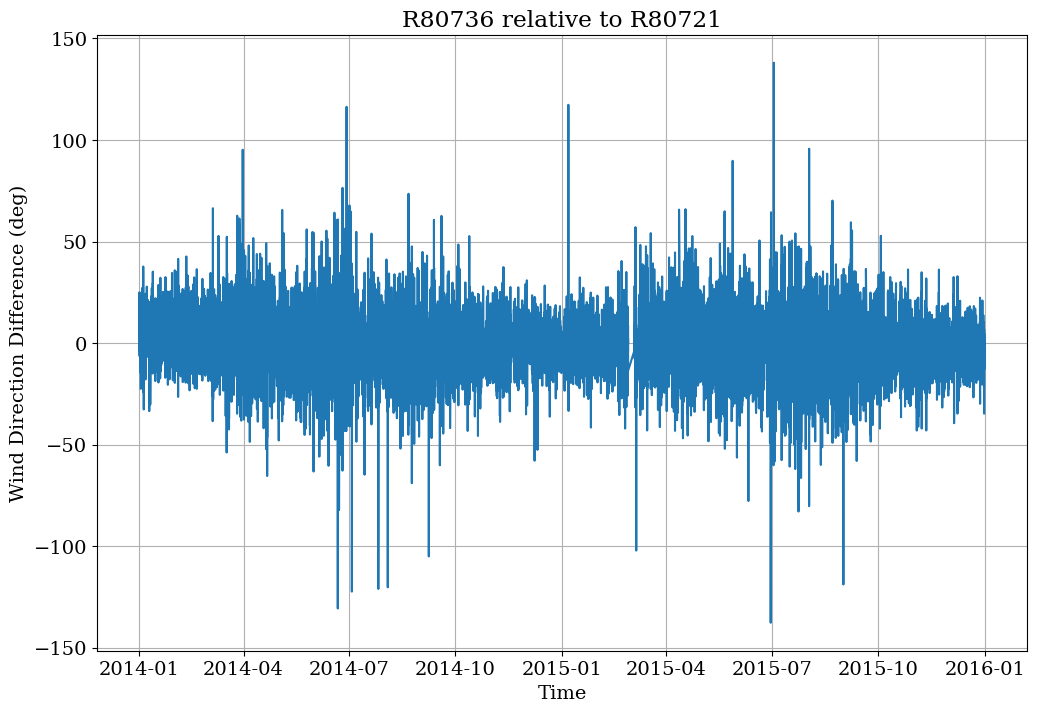

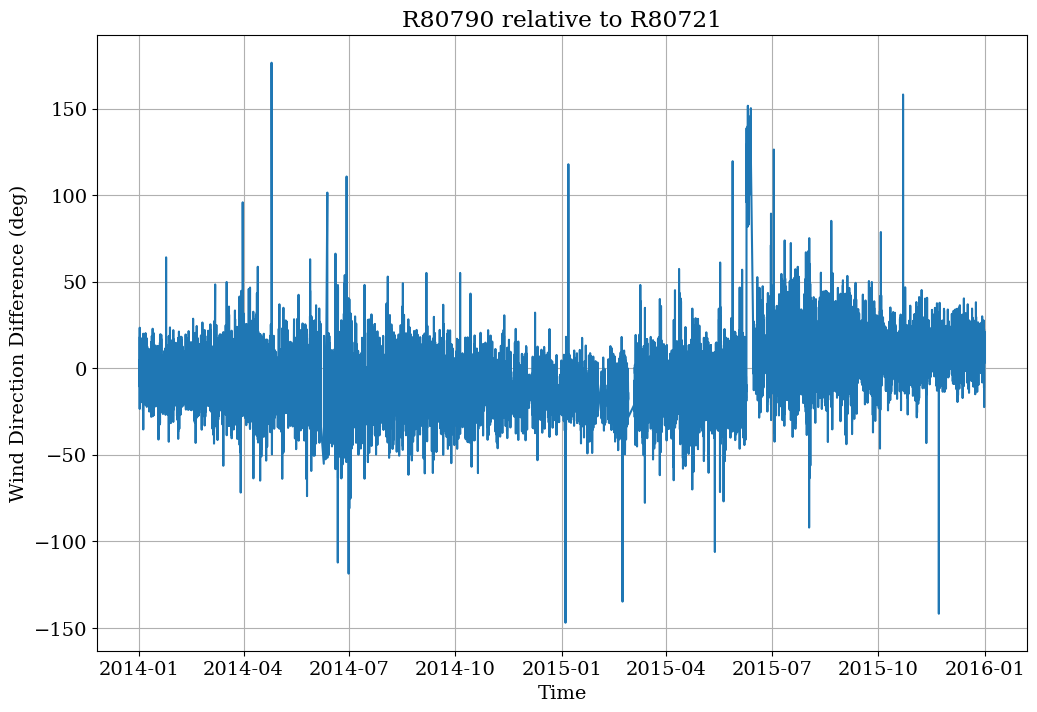

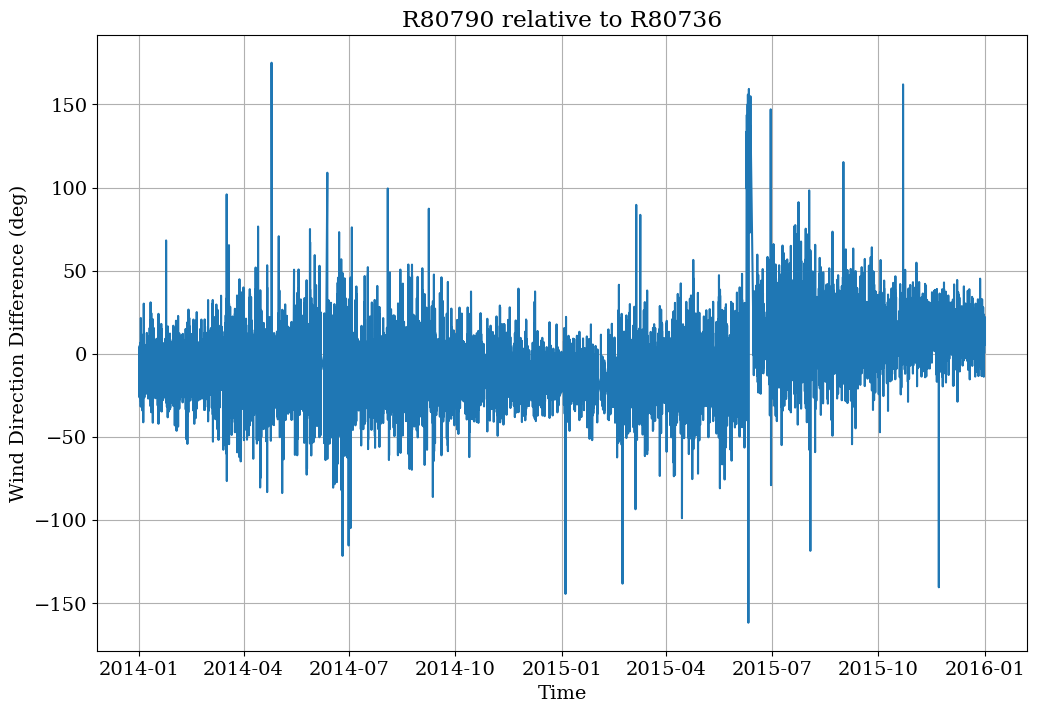

In [6]:
for ind1, tid1 in enumerate(project.turbine_ids):
    for tid2 in [tid for ind, tid in enumerate(project.turbine_ids) if ind > ind1]:
    
        # limit to time steps when both turbines are producing power
        valid_indices = (scada_df[("power",tid1)] >= 0) & (scada_df[("power",tid2)] >= 0)

        plt.figure(figsize=(12, 8))
        plt.plot(scada_df.index[valid_indices],met.wrap_180(scada_df.loc[valid_indices,("wind_direction",tid2)].values - scada_df.loc[valid_indices,("wind_direction",tid1)].values))
        plt.xlabel("Time")
        plt.ylabel("Wind Direction Difference (deg)")
        plt.title(f"{tid2} relative to {tid1}")

For the first three plots showing the difference between the wind direction measured by turbine R80711 and the three other turbines, there is a short period around November 2015 when the northing offset of one of the turbines changes. Since this change is only present for turbine pairs containing turbine R80711, we'll conclude that the northing offset change occurs for turbine R80711. Upon closer investigation, the change occurs shortly after November 25, 2015.

For the plot showing the difference between the wind directions measured by turbines R80721 and R80736, there is no noticeable change in the norhting offset, so we'll assume that these two turbines have constant northing offsets during the period of record.

Lastly, for the two plots showing the difference between the wind directions measured by turbine R80790 and turbines R80721 and R80736, there appears to be a significant change in the relative offset in mid-2015, which we'll assume is caused by turbine R80790 (because no change in offset was observed for turbines R80721 and R80736 as discussed above). Although we could try to correct the change in northing offset, we'll simplify the analysis here by excluding turbine R80790's wind direction signal from the representative wind plant wind direction calculation.  

In summary, we will use wind direction measurements from turbines R80711, R80721, and R80736 but limit the date range to prior to November 25, 2015.

### Identify any wind direction biases between turbine pairs

Next, we'll determine whether there are any significant constant biases between the wind directions measured at the three reliable turbines during the roughly two-year period. The plots in the previous step do not show large biases between wind directions measured by different turbines (aside from the periods identified), but we'll double check this here.    

In [7]:
turbine_ids_sub = [tid for tid in project.turbine_ids if tid != "R80790"]

wind_direction_bias_df = pd.DataFrame(index=turbine_ids_sub, columns = turbine_ids_sub)

for tid1 in turbine_ids_sub:
    for tid2 in turbine_ids_sub:
        
        # limit to time steps when both turbines are producing power
        valid_indices = (scada_df[("power",tid1)] >= 0) & (scada_df[("power",tid2)] >= 0)
        
        # further limit to dates prior to 11/25/2015
        valid_indices = valid_indices & (scada_df.index < "2015-11-25 00:00")
        
        wind_direction_bias_df.loc[tid1,tid2] = np.mean(met.wrap_180(scada_df.loc[valid_indices, ("wind_direction",tid2)].values - scada_df.loc[valid_indices, ("wind_direction",tid1)].values))
        
wind_direction_bias_df

,R80711,R80721,R80736
R80711,0.0,2.885641,2.795791
R80721,-2.885641,0.0,-0.123917
R80736,-2.795791,0.123917,0.0


The matrix above reveals that the mean difference between the wind directions measured by the three reliable turbines is no more than +/- 3 degrees. Since this is a relatively small bias, we'll assume that there is no significant bias between the wind directions measured by the three turbines worth correcting. 

### Determine the northing offset and correct wind direction signals for each turbine

Lastly, we'll estimate the northing offset for the three reliable turbines. To do so, we'll plot the ratio of the average power produced by pairs of turbines as a function of wind direction. From these plots we'll compare the measured direction of peak wake losses between the upstream and downsteam turbines to the actual direction between the turbines (where peak wake losses are expected) to determine the offset.   

Specifically, we'll choose the turbine pairs R80711/R80790 and R80736/R80721, where turbines R80711 and R80736 are the upstream turbines when the wind is from the north and south, respectively. We expect to observe peak wake losses when the wind direction is equal to the direction of alignment between the upstream and downstream turbines.

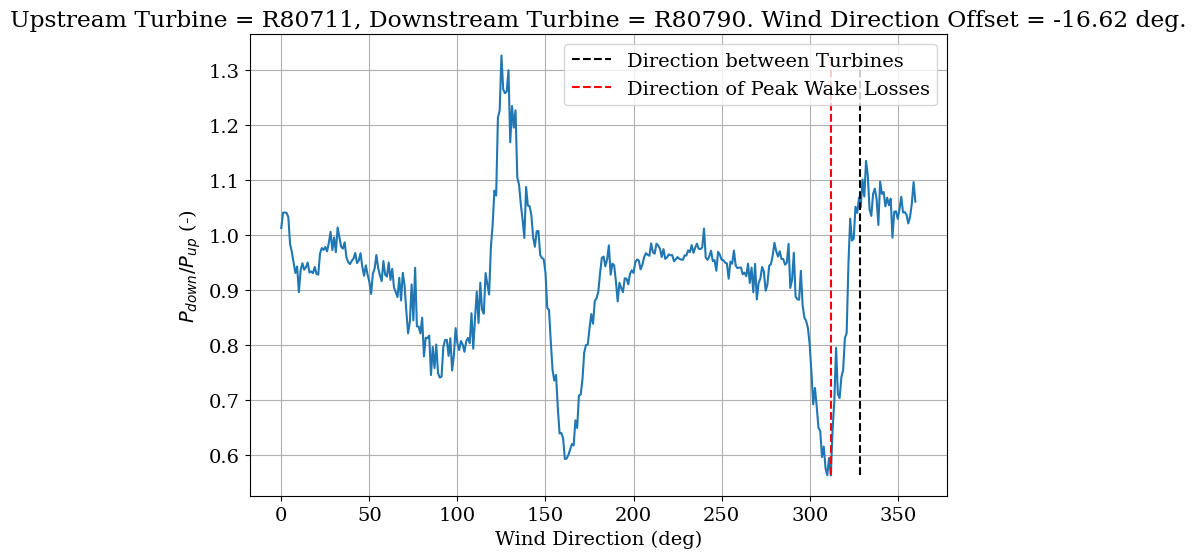

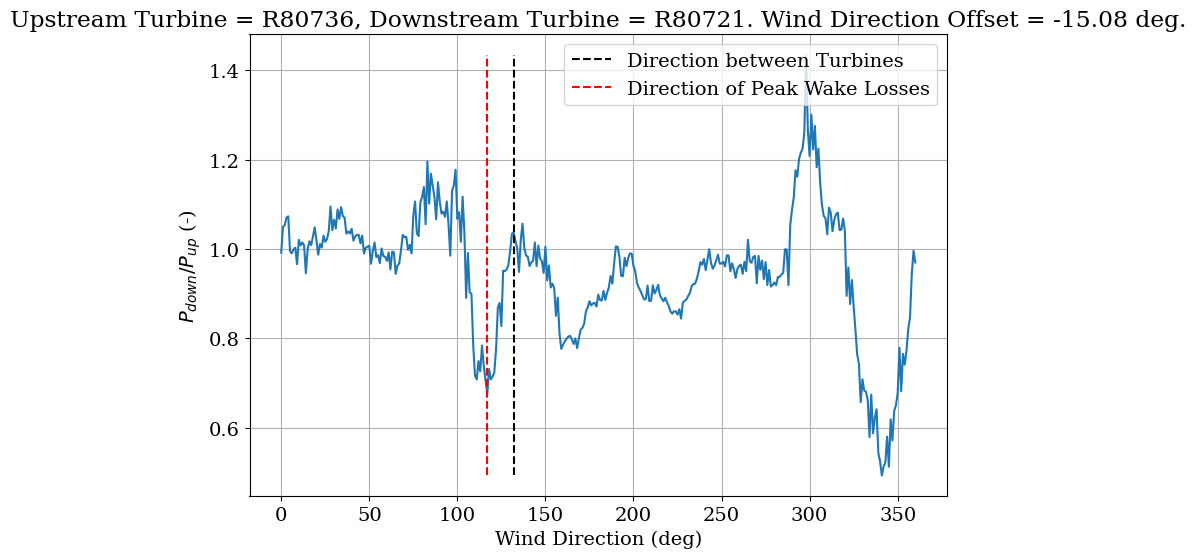

In [8]:
turbine_id_pairs = [("R80711","R80790"),("R80736","R80721")]

for tid_up, tid_down in turbine_id_pairs:

    # limit to time steps when both turbines are producing power
    valid_indices = (scada_df[("power",tid_up)] >= 0) & (scada_df[("power",tid_down)] >= 0)

    # further limit to dates prior to 11/25/2015
    valid_indices = valid_indices & (scada_df.index < "2015-11-25 00:00")

    scada_df[("wind_direction_bin",tid_up)] = scada_df[("wind_direction",tid_up)].round()

    scada_df_bin = scada_df.loc[valid_indices].groupby(("wind_direction_bin",tid_up)).mean()

    turbine_pair_direction = project.turbine_direction_matrix().loc[tid_down,tid_up]

    # ratio between mean power of downstream and upstream turbines vs. wind direction
    power_ratio = scada_df_bin[("power",tid_down)]/scada_df_bin[("power",tid_up)]
    
    # Find direction where peak wake losses are observed, assuming this direction is within 45 degrees 
    # of actual direction between turbines
    peak_wake_loss_direction = np.round(turbine_pair_direction) - 45.0 + np.argmin(power_ratio[np.round(turbine_pair_direction)-45:np.round(turbine_pair_direction)+45])

    # Wind direction offset
    direction_offset = np.round(met.wrap_180(peak_wake_loss_direction - turbine_pair_direction),2)
    
    plt.figure(figsize=(9,6))
    plt.plot(power_ratio,label="_nolabel_")

    plt.plot(2*[turbine_pair_direction],[power_ratio.min(),power_ratio.max()],'k--',label = "Direction between Turbines")
    plt.plot(2*[peak_wake_loss_direction],[power_ratio.min(),power_ratio.max()],'r--',label = "Direction of Peak Wake Losses")
    plt.legend()
    plt.xlabel("Wind Direction (deg)")
    plt.ylabel("$P_{down}/P_{up}$ (-)")
    plt.title(f"Upstream Turbine = {tid_up}, Downstream Turbine = {tid_down}. Wind Direction Offset = {direction_offset} deg.")

For the two turbine pairs there is an offset of -15 to -16 degrees between the direction of peak wake losses and the actual direction of alignment between the upstream and downstream turbines. Note that for the turbine pair R80736/R80721 the largest wake losses actually occur near 335 degrees, but after comparing the power ratio vs. wind direction plot to the wind plant layout, we can infer that these wake losses are not caused by turbine R80736 waking R80721.

We will use the average northing offset of -15.85 degrees observed for the two turbine pairs as the northing offset to apply to all three turbines. To complete the wind direction correction process, we'll add this northing offset to the wind direction signals for each turbine.

In [9]:
project.scada["wind_direction"] = (project.scada["wind_direction"] - -15.85) % 360.0

## Wake loss estimation without uncertainty quantification

First, we'll create a WakeLosses object without uncertainty quantification (`UQ`=False) using our `PlantData` object called `project` for La Haute Borne. The remainder of the WakeLosses arguments are described below. Note that aside from the arguments `wind_direction_asset_ids` and `end_date`, the default values are all used here.

  - `wind_direction_col`: The SCADA or met tower wind direction column name.
  - `wind_direction_data_type`: The data type used to determine the wind direction ("scada" or "tower").
  - `wind_direction_asset_ids`: The subset of asset IDs (turbines or met towers) to use to calculate the representative average wind direction for the wind plant at each time step. Note that by using the default value of None, all asset IDs will be used. Here we are specifying the three reliable wind turbines identified earlier in the notebook.
  - `start_date`: The earliest date for SCADA data (and met tower data, if applicable) to include when computing wake losses.
  - `end_date`: The last date for SCADA data (and met tower data, if applicable) to include when computing wake losses. Here we are limiting the analysis to dates before November 25, 2015, when we observed a northing offset change for turbine R80711.
  - `reanal_products`: The set of reanalysis products to use when estimating long-term corrected wake losses. Note that because we set `UQ`=False, the average wake losses estimated for each reanalysis product will be used as the single long-term corrected wake loss value.
  - `end_date_lt`: The most recent date for reanalysis data to include in the long-term correction process.  

In [10]:
wl = WakeLosses(
    plant=project,
    wind_direction_col="wind_direction",
    wind_direction_data_type="scada",
    wind_direction_asset_ids=["R80711", "R80721", "R80736"],
    start_date=None,
    end_date="2015-11-25 00:00",
    reanal_products=["merra2","era5"],
    end_date_lt=None,
    UQ=False
)

INFO:openoa.analysis.wake_losses:Initializing WakeLosses analysis object
INFO:openoa.analysis.wake_losses:Note: uncertainty quantification will NOT be performed in the calculation


Next, we'll run the wake loss analysis method, which contains the following arguments. Note that aside from the argument `no_wakes_ws_thresh_LT_corr` we are using the default values for each argument.

  - `num_sim`: The number of Monte Carlo iterations to perform to quantify uncertainty. This argument is ignored here because we set `UQ`=`False`; only one iteration will be performed.
  - `wd_bin_width`: The wind direction bin size to use when determining the set of freestream wind turbines as a function of wind direction (degrees).
  - `freestream_sector_width`: The wind direction sector width used to determine whether a turbine is waked or experiencing freestream inflow (degrees). For each turbine, if there are no other turbines located upstream in the wind direction sector given by +/- half of the freestream sector width from the wind direction bin value, the turbine will be classified as freestream.  
  - `freestream_power_method`: The averaging method used to determine the average power production of the freestream turbines ("mean", "median", or "max").
  - `freestream_wind_speed_method`: The averaging method used to determine the average wind speed of the freestream turbines ("mean" or "median").
  - `correct_for_derating`: Specifies whether derated, curtailed, or otherwise unavailable turbines should be flagged and excluded from the calculation of potential wind plant power production. If True, potential freestream power production will be calculated as the sum of the derated turbine powers and the mean power of the freestream turbines operating normally multiplied by the number of turbines operating normally.
  - `derating_filter_wind_speed_start`: The wind speed above which turbines will be flagged as derated/curtailed/shutdown if power is less than 1% of rated power (m/s).
  - `max_power_filter`: The maximum power, defined as a fraction of rated power, to which a power curve bin filter will be applied to identify derated/curtailed/shutdown turbines.
  - `wind_bin_mad_thresh`: The filter threshold for each power bin used to identify derated/curtailed/shutdown turbines, expressed as the number of median absolute deviations above the median wind speed in the power bin.
  - `wd_bin_width_LT_corr`: Size of wind direction bins used to calculate long-term frequencies from historical reanalysis data in the long-term correction process.
  - `ws_bin_width_LT_corr`: Size of wind speed bins used to calculate long-term frequencies from historical reanalysis data in the long-term correction process.
  - `num_years_LT`: The number of years of historical reanalysis data to use in the long-term correction process.
  - `assume_no_wakes_high_ws_LT_corr`: If `True`, wind direction and wind speed bins for which operational data are missing above a certain wind speed threshold are corrected by assigning the wind turbines' rated power to both the actual and potential power production variables during the long term-correction process.
  - `no_wakes_ws_thresh_LT_corr`: The wind speed threshold (inclusive) above which rated power is assigned to both the actual and potential power production variables if operational data are missing for any wind direction and wind speed bin during the long term-correction process. This wind speed corresponds to the wind speed measured at freestream wind turbines. Although the default value is 13 m/s, we'll use a value of 15 m/s here because the turbines at La Haute Borne have a relatively high rated wind speed.

In [11]:
wl.run(
    num_sim = 1,
    wd_bin_width = 5.0,
    freestream_sector_width = 90.0,
    freestream_power_method = "mean",
    freestream_wind_speed_method = "mean",
    correct_for_derating = True,
    derating_filter_wind_speed_start = 4.5,
    max_power_filter = 0.95,
    wind_bin_mad_thresh = 7.0,
    wd_bin_width_LT_corr = 5.0,
    ws_bin_width_LT_corr = 1.0,
    num_years_LT = 20,
    assume_no_wakes_high_ws_LT_corr = True,
    no_wakes_ws_thresh_LT_corr = 15.0
)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


### Analysis of wind plant wake losses

Now, we'll print the plant-level wake losses for the period of record as well as the long-term corrected wake losses. 

The plant level wake losses are very small (< 1%) for both the period of record and after long-term correction.

In [12]:
print(f"Period-of-record wake losses: {wl.wake_losses_por:.2%}")
print(f"Long-term corrected wake losses: {wl.wake_losses_lt:.2%}")

Period-of-record wake losses: 0.34%
Long-term corrected wake losses: 0.37%


To better understand why the wake losses are so small, we'll plot the wake losses as a function of wind direction and wind speed.

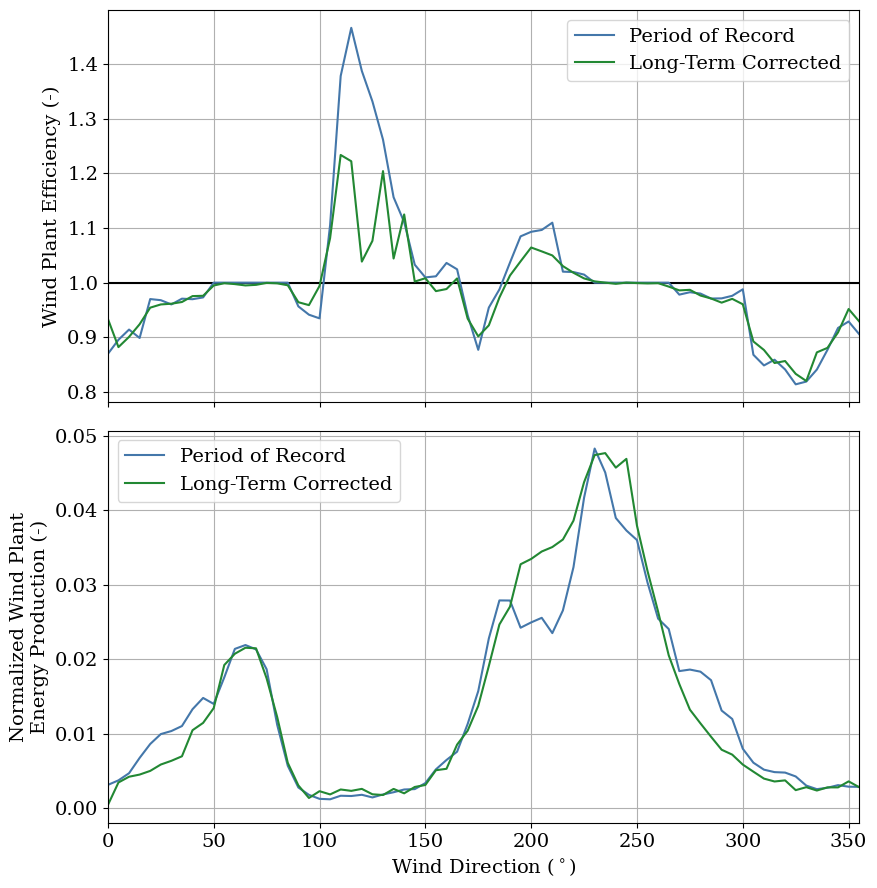

In [13]:
axes = wl.plot_wake_losses_by_wind_direction()

The first plot above confirms that the wind plant experiences significant wake losses (i.e., a wind plant efficiency less than one) when the wind is from the north and south, as expected given the wind plant layout (turbines are located downstream of other turbines in the north/south direction). However, apparent negative wake losses (a wind plant efficiency greater than one) are computed when the wind is from the southeast and southwest. This indicates that the freestream turbines generate less power than the turbines identified as waked for these wind directions, suggesting that one of the core assumptions in the wake loss estimation method&mdash;that in the absence of wake losses, all turbines in the wind plant would generate the same amount of power on average&mdash;is invalid. This could be due to terrain effects or nearby forested regions (visible in the wind plant map) affecting the wind speeds differently at individual turbine locations.

As revealed by the distribution of wind plant energy production as a function of wind direction in the second plot above, most of the wind plant's energy is produced at wind directions where wake losses are very low (from the east and southwest). This helps explain why the overall wake losses are less than 1%.

Next, we'll plot the wake losses as a function of wind speed.

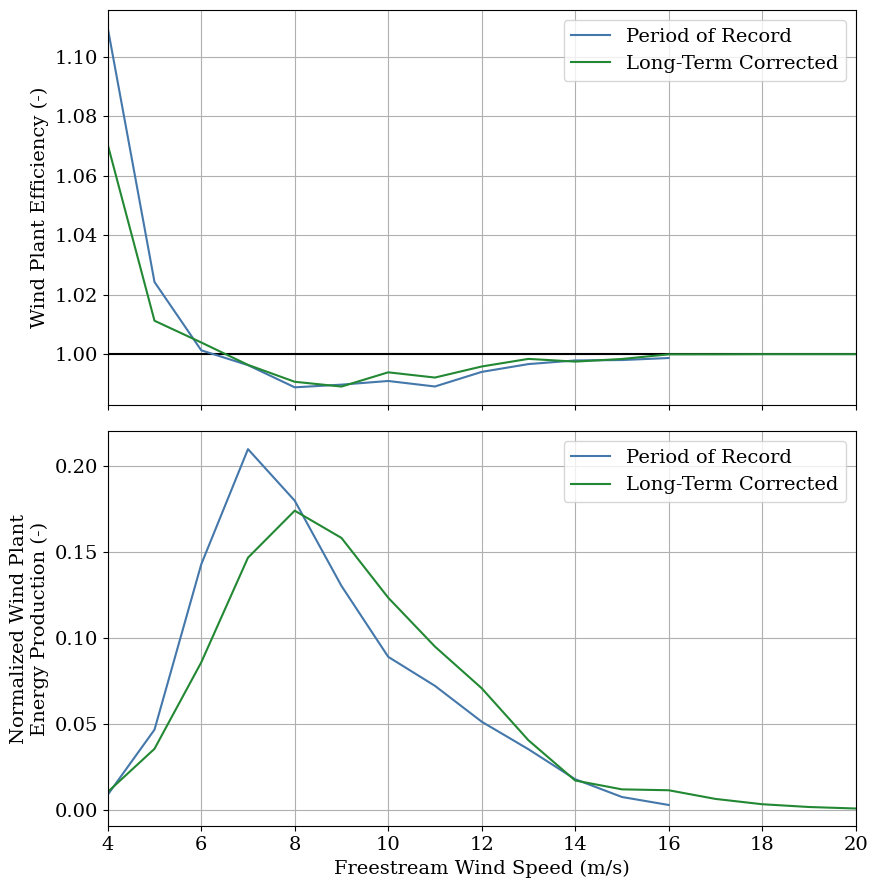

In [14]:
axes = wl.plot_wake_losses_by_wind_speed()

Interestingly, the first plot above shows a wind farm efficiency greater than one (apparent negative wake losses) for low wind speeds (5 m/s and below). However, as shown in the second plot, the contribution of these low wind speeds to the total energy produced by the wind plant is relatively low. Therefore, these physically unrealistic wake losses likely don't contribute to the overall wake losses much.

Wake losses are at their peak (but only ~1%) when the turbines are maximizing their power production in below-rated wind speeds. As expected, the wake losses decrease as the wind speed approaches the rated wind speed of approximately 15 m/s. 

Note that the distribution of energy production as a function of wind speed in the second plot suggests that the long-term wind speeds expected at the site are on average greater than the wind speeds measured during the two-year period of record.

### Analysis of turbine-level wake losses

Next, we'll print the turbine-level wake losses for the period of record as well as the long-term corrected wake losses. 

Interestingly, the wake losses at individual turbines range from unrealistic large negative values near -10% to more realstic large positive wake losses near +10%. The very low wind plant wake losses therefore appear to be caused by large negative and positive wake losses at individual turbines nearly cancelling out. 

In [15]:
for i in range(len(wl.turbine_ids)):
    print(f"Period-of-record wake losses for turbine {wl.turbine_ids[i]}: {np.round(100*wl.turbine_wake_losses_por[i],2)}%")
    
for i in range(len(wl.turbine_ids)):
    print(f"Long-term corrected wake losses for turbine {wl.turbine_ids[i]}: {np.round(100*wl.turbine_wake_losses_lt[i],2)}%")

Period-of-record wake losses for turbine R80711: -11.73%
Period-of-record wake losses for turbine R80721: 10.9%
Period-of-record wake losses for turbine R80736: 4.07%
Period-of-record wake losses for turbine R80790: -1.9%
Long-term corrected wake losses for turbine R80711: -9.72%
Long-term corrected wake losses for turbine R80721: 10.28%
Long-term corrected wake losses for turbine R80736: 2.93%
Long-term corrected wake losses for turbine R80790: -2.04%


Again, to better understand why the turbine-level wake losses can be so extreme, we'll plot the wake losses for turbines R80711 and R80721 as a function of wind direction and wind speed.

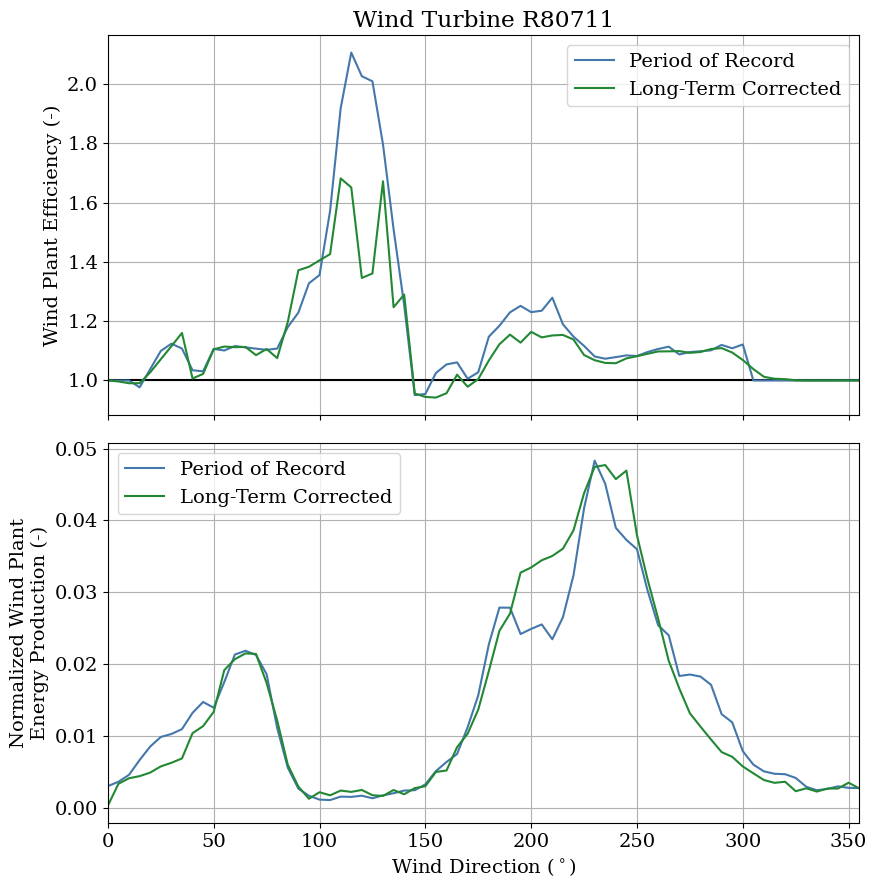

In [16]:
axes = wl.plot_wake_losses_by_wind_direction(turbine_id = "R80711")

For turbine R80711, the northernmost turbine in the wind plant, for which physically unrealistic negative wake losses of roughly -10% were estimated, some wake losses are present when the wind is from the southeast, as expected. But for nearly all other wind directions, the wind turbine efficiency is signficantly greater than one, suggesting that the turbine outperforms the set of freestream wind turbines. This could be due to the effects of local terrain, forested regions, or generally higher turbine performance for R80711 independent of wake effects.

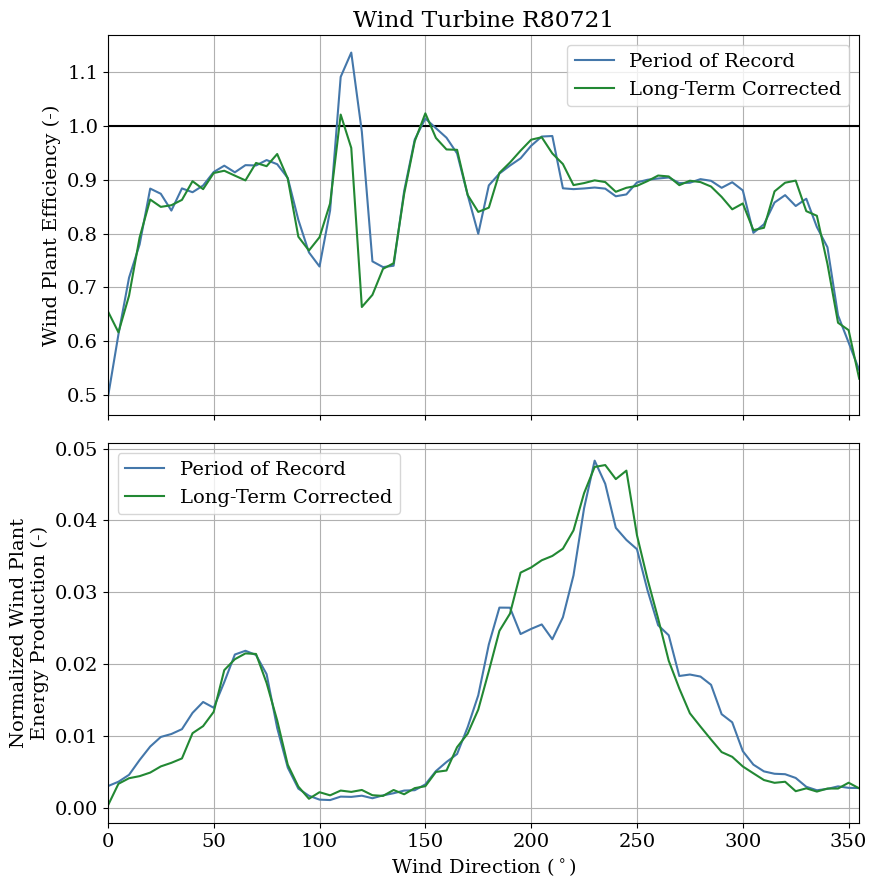

In [17]:
axes = wl.plot_wake_losses_by_wind_direction(turbine_id = "R80721")

For turbine R80721, one of the "interior" turbines in the wind plant, for which large wake losses of roughly 10% were estimated, significant wake losses are observed for almost all wind directions. Based on the wind plant layout, significant wake losses are expected when the wind is from the north or southeast. However, the presence of large wake losses when the wind is from the east or west, and no other turbines are upstream of R80721, suggests that this tubrbine may generally experience lower wind speeds than other turbines because of the effects of terrain or nearby forests, or may generally perform worse than other turbines independent of inflow conditions. 

Next, we'll plot the wake losses as a function of wind speed for turbines R80711 and R80721.

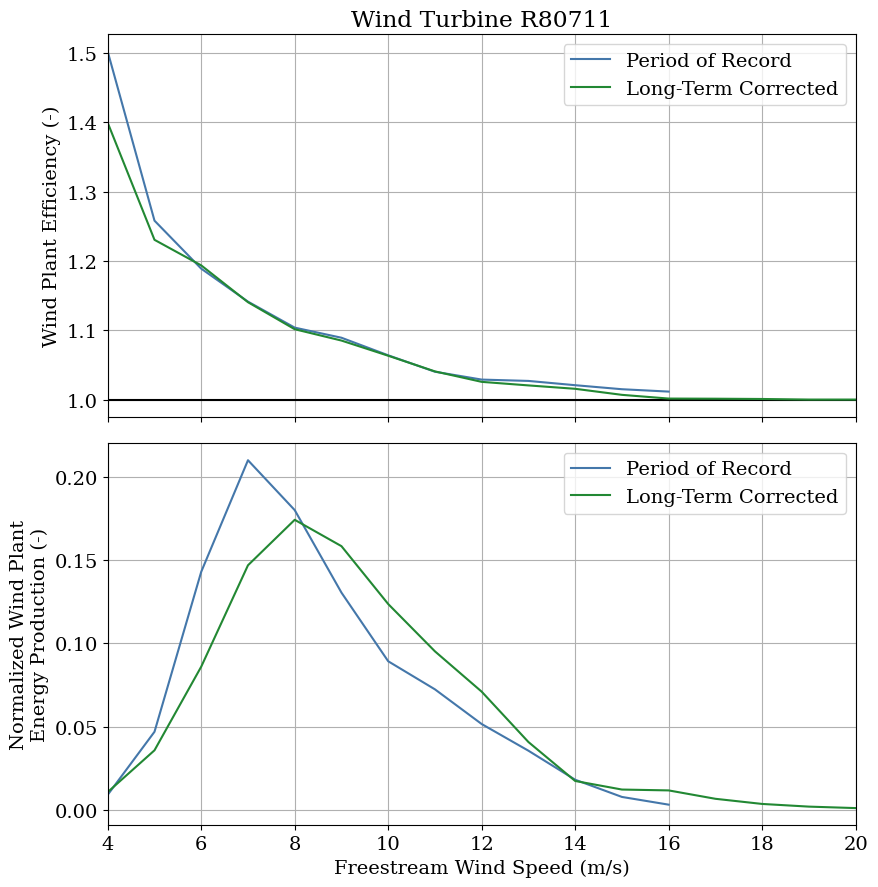

In [18]:
axes = wl.plot_wake_losses_by_wind_speed(turbine_id = "R80711")

The plots above show that unrealistic negative wake losses are estimated for turbine R80711 for all wind speeds, helping to explain the overall negative wake losses of  roughly -10% estimated for the turbine. Note that as wind speed increases toward rated wind speed, the overperformance of this turbine relative to the other turbines in the wind plant decreases.

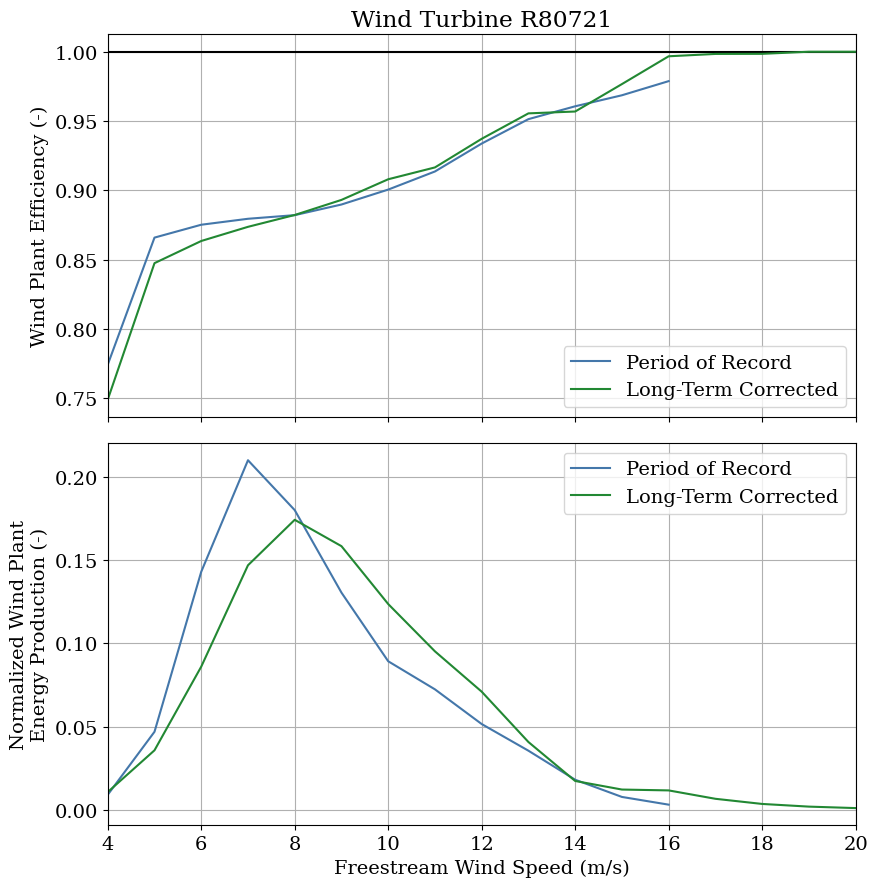

In [19]:
axes = wl.plot_wake_losses_by_wind_speed(turbine_id = "R80721")

The plots above for turbine R80721 show nearly the opposite trend as observed for turbine R80721: as we would expect, positive wake losses are observed for all wind speeds, decreasing as wind speed approaches rated wind speed. This result agrees with the large overall wake losses of ~10% estimated for turbine R80721.

## Wake loss estimation with uncertainty quantification

Next, we'll repeat the wake loss analysis by creating a new WakeLosses object, but this time with uncertainty quantification enabled (UQ=True).

In [20]:
wl = WakeLosses(
    plant=project,
    wind_direction_col="wind_direction",
    wind_direction_data_type="scada",
    wind_direction_asset_ids=["R80711", "R80721", "R80736"],
    start_date=None,
    end_date="2015-11-25 00:00",
    reanal_products=["merra2","era5"],
    end_date_lt=None,
    UQ=True
)

INFO:openoa.analysis.wake_losses:Initializing WakeLosses analysis object
INFO:openoa.analysis.wake_losses:Note: uncertainty quantification will be performed in the calculation


Next, we'll run the wake loss analysis with uncertainty quantification. Because many of the arguments are the same as for the case without uncertainty quantification, only the arguments that are different are described below. Note that aside from the argument `no_wakes_ws_thresh_LT_corr` we are using the default values for each argument for the case when `UQ=True`. For each tuple argument, during each Monte Carlo iteration a random value will be chosen in the range between the minimum and maximum values specified. Similarly, a random reanalysis product used in the long-term correction process will be selected each iteration from the full set of reanalysis products specified. 

  - `num_sim`: The number of Monte Carlo iterations to perform to quantify uncertainty.
  - `freestream_sector_width`: The minimum and maximum wind direction sector widths used to determine whether a turbine is waked or experiencing freestream inflow (degrees). For each turbine, if there are no other turbines located upstream in the wind direction sector given by +/- half of the freestream sector width from the wind direction bin value, the turbine will be classified as freestream.  
  - `derating_filter_wind_speed_start`: The minimum and maximum wind speed thresholds above which turbines will be flagged as derated/curtailed/shutdown if power is less than 1% of rated power (m/s).
  - `max_power_filter`: The range (minimum and maximum) of maximum power values, defined as a fraction of rated power, to which a power curve bin filter will be applied to identify derated/curtailed/shutdown turbines.
  - `wind_bin_mad_thresh`: The minimum and maximum filter thresholds for each power bin used to identify derated/curtailed/shutdown turbines, expressed as the number of median absolute deviations above the median wind speed in the power bin. 
  - `num_years_LT`: The minimum and maximum numbers of years of historical reanalysis data to use in the long-term correction process.

In addition to randomly sampling the analysis parameters described above each Monte Carlo iteration, bootstrapping is used to further quantify uncertainty. Each iteration, a set of time steps sampled randomly with replacement from the full data set is used to compute wake losses. Additionally, for each wind direction, a set of freestream turbines sampled randomly with replacement from the identified set of freestream turbines is used to compute potential wind plant power production each iteration.

Note: with 100 iterations, this command can take a few minutes to execute.

In [21]:
wl.run(
    num_sim = 100,
    wd_bin_width = 5.0,
    freestream_sector_width = (50.0, 110.0),
    freestream_power_method = "mean",
    freestream_wind_speed_method = "mean",
    correct_for_derating = True,
    derating_filter_wind_speed_start = (4.0, 5.0),
    max_power_filter = (0.92, 0.98),
    wind_bin_mad_thresh = (4.0, 13.0),
    wd_bin_width_LT_corr = 5.0,
    ws_bin_width_LT_corr = 1.0,
    num_years_LT = (10, 20),
    assume_no_wakes_high_ws_LT_corr = True,
    no_wakes_ws_thresh_LT_corr = 15.0
)

100%|█████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


### Analysis of wind plant wake losses

Now, we'll print the mean plant-level wake losses together with the standard deviation and 95% confidence interval for the period of record as well as the long-term corrected wake losses. 

The mean plant level wake losses are slightly larger than the values estimated without uncertainty quantification, but are still very small (< 1%) for both the period of record and after long-term correction.

However, the standard deviation of the wake loss estimates and their 95% confidence intervals are very large relative to the small mean wake losses estimated, suggesting that we should not place much trust in the exact values for the period-of-record and long-term corrected wake losses, respectively. 

In [22]:
print(f"Mean period-of-record wake losses: {wl.wake_losses_por_mean:.2%}")
print(f"Mean long-term corrected wake losses: {wl.wake_losses_lt_mean:.2%}")

print(f"Standard deviation of period-of-record wake losses: {wl.wake_losses_por_std:.2%}")
print(f"Standard deviation of long-term corrected wake losses: {wl.wake_losses_lt_std:.2%}")

print(f"95% confidence interval of period-of-record wake losses: [{np.percentile(wl.wake_losses_por,2.5):.2%}, {np.percentile(wl.wake_losses_por,97.5):.2%}]")
print(f"95% confidence interval of long-term corrected wake losses: [{np.percentile(wl.wake_losses_por,2.5):.2%}, {np.percentile(wl.wake_losses_lt,97.5):.2%}]")

Mean period-of-record wake losses: 0.21%
Mean long-term corrected wake losses: 0.36%
Standard deviation of period-of-record wake losses: 1.62%
Standard deviation of long-term corrected wake losses: 1.55%
95% confidence interval of period-of-record wake losses: [-2.77%, 2.84%]
95% confidence interval of long-term corrected wake losses: [-2.77%, 2.80%]


Although the plots of wind plant efficiency vs. wind direction and wind speed show the same trends as for the case without uncertainty quantification, the plots below illustrate the significant uncertainty, via the 95% confidence interval, of the wake losses as a function of the wind conditions. 

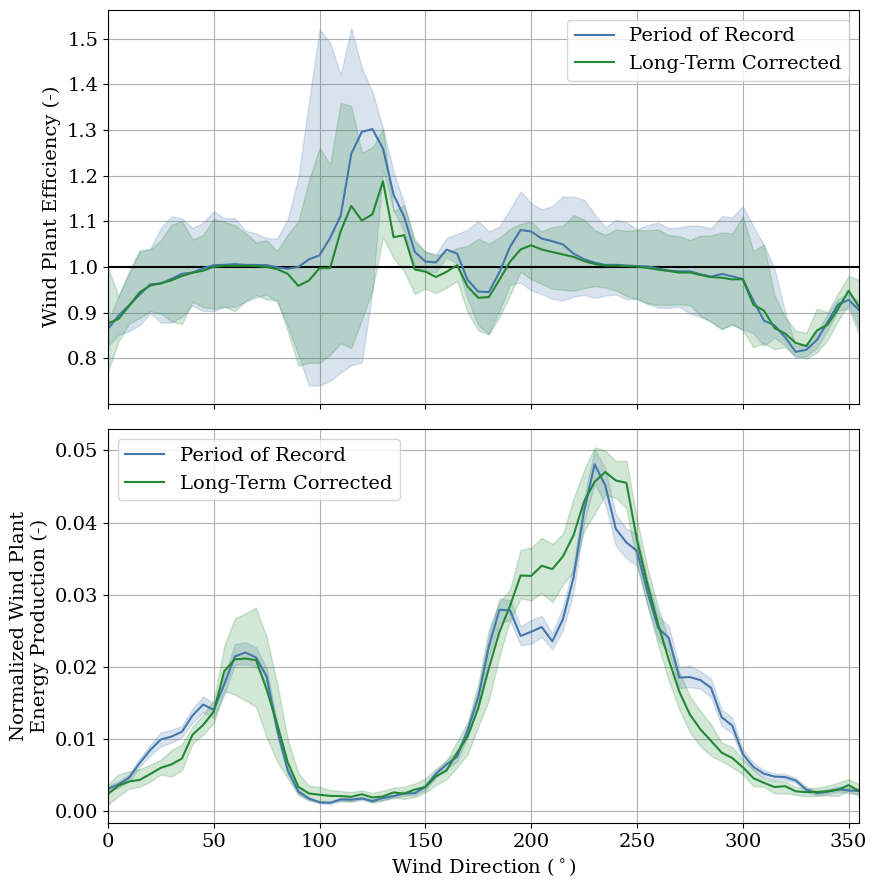

In [23]:
axes = wl.plot_wake_losses_by_wind_direction()

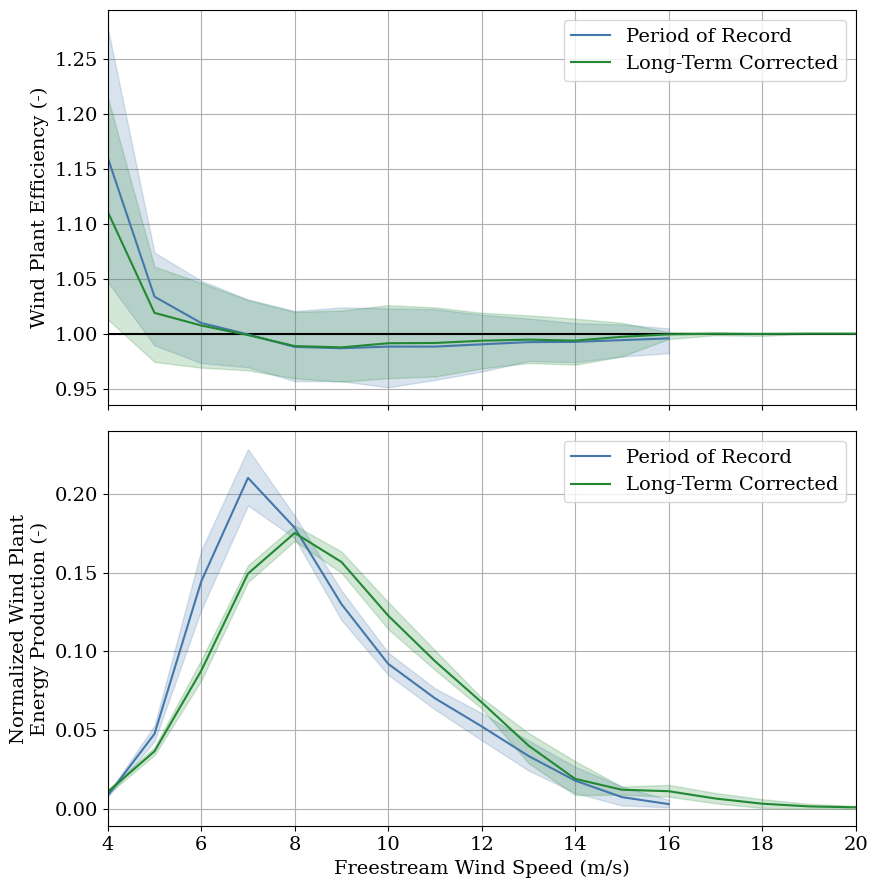

In [24]:
axes = wl.plot_wake_losses_by_wind_speed()

### Analysis of turbine-level wake losses

Next, we'll print the mean turbine-level wake losses together with the standard deviations and 95% confidence intervals for the period of record as well as the long-term corrected wake losses. 

Similar to the results without uncertainty quantification, the mean wake losses at individual turbines range from unrealistic large negative values near -10% to more realstic large positive wake losses near +10%. 

As observed for the wind plant-level wake losses, the standard deviations and 95% confidence intervals are very large relative to the magnitude of the mean wake losses, suggesting that we shouldn't place too much trust in the exact mean wake losses for each turbine. However, the entire 95% confidence intervals of the wake losses for turbines R80711 and R80721 remain less than zero and above zero, respectively. For turbine R80711, this suggests that the unrealistic negative wake loss estimates are not simply a product of estimation uncertainty, but are caused by systematic effects such as local terrain or vegetation variations across the wind plant or variations in general wind turbine performance independent of wake effects.

In [25]:
for i in range(len(wl.turbine_ids)):
    print(f"Turbine {wl.turbine_ids[i]}:")
    print(f"Mean period-of-record wake losses: {wl.turbine_wake_losses_por_mean[i]:.2%}")
    print(f"Standard deviation of period-of-record wake losses: {wl.turbine_wake_losses_por_std[i]:.2%}")
    print(f"95% confidence interval of period-of-record wake losses: [{np.percentile(wl.turbine_wake_losses_por[:,i],2.5):.2%}, {np.percentile(wl.turbine_wake_losses_por[:,i],97.5):.2%}]")
    print(f"Mean long-term corrected wake losses: {wl.turbine_wake_losses_lt_mean[i]:.2%}")
    print(f"Standard deviation of long-term corrected wake losses: {wl.turbine_wake_losses_lt_std[i]:.2%}")
    print(f"95% confidence interval of long-term corrected wake losses: [{np.percentile(wl.turbine_wake_losses_lt[:,i],2.5):.2%}, {np.percentile(wl.turbine_wake_losses_lt[:,i],97.5):.2%}]\n")

Turbine R80711:
Mean period-of-record wake losses: -11.84%
Standard deviation of period-of-record wake losses: 1.82%
95% confidence interval of period-of-record wake losses: [-15.17%, -8.83%]
Mean long-term corrected wake losses: -9.74%
Standard deviation of long-term corrected wake losses: 1.71%
95% confidence interval of long-term corrected wake losses: [-12.68%, -6.61%]

Turbine R80721:
Mean period-of-record wake losses: 10.78%
Standard deviation of period-of-record wake losses: 1.46%
95% confidence interval of period-of-record wake losses: [8.02%, 13.14%]
Mean long-term corrected wake losses: 10.31%
Standard deviation of long-term corrected wake losses: 1.47%
95% confidence interval of long-term corrected wake losses: [7.41%, 12.82%]

Turbine R80736:
Mean period-of-record wake losses: 3.92%
Standard deviation of period-of-record wake losses: 1.55%
95% confidence interval of period-of-record wake losses: [1.14%, 6.42%]
Mean long-term corrected wake losses: 2.84%
Standard deviation o

Lastly, we'll plot the wake losses as a function of wind direction and wind speed for turbines R80711 and R80721 with uncertainty illustrated as the 95% confidence interval. Although no new trends are revealed compared to the plots without uncertainty quantification, these plots highlight the significant uncertainty in the wake loss estimates as a function of the wind conditions. 

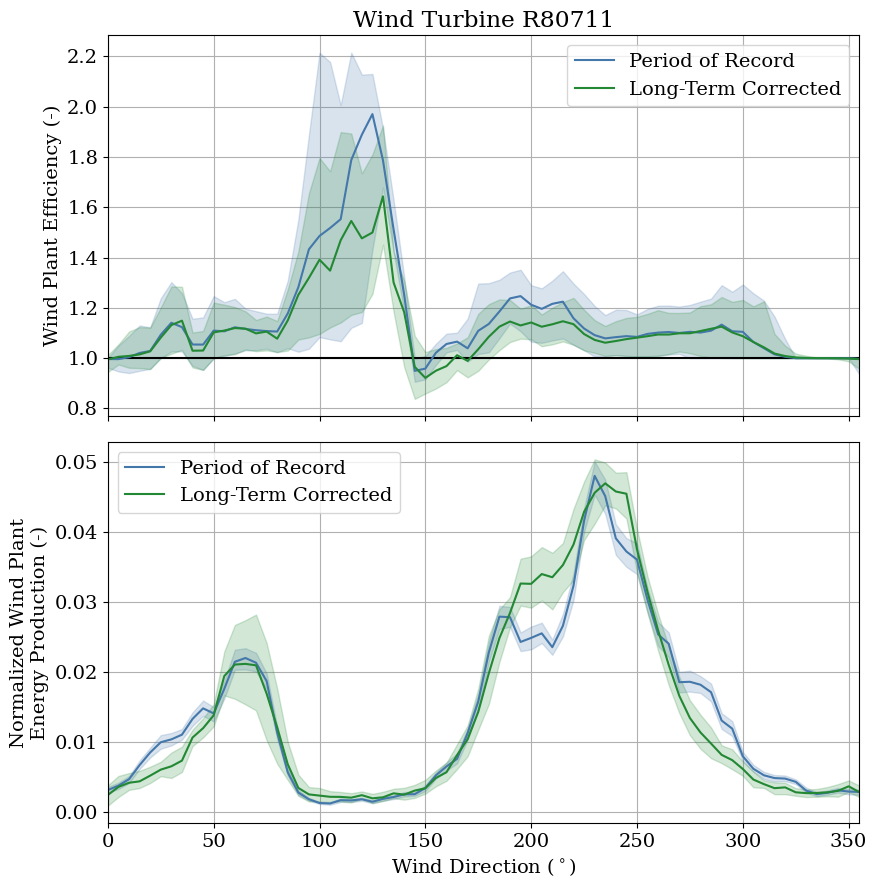

In [26]:
axes = wl.plot_wake_losses_by_wind_direction(turbine_id = "R80711")

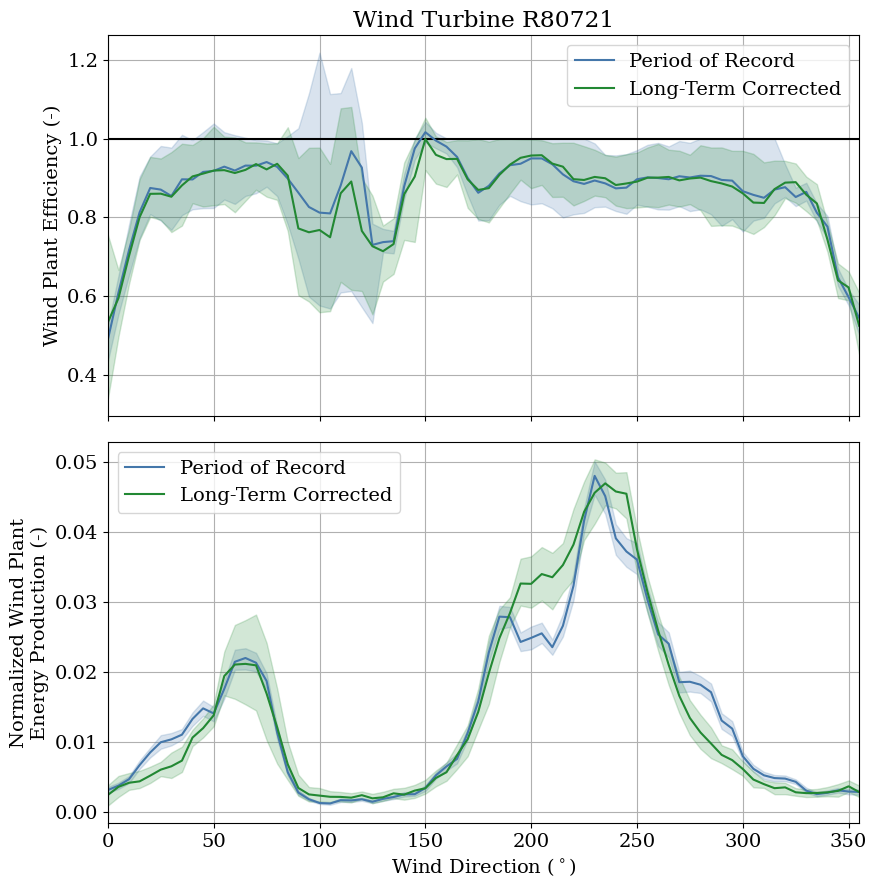

In [27]:
axes = wl.plot_wake_losses_by_wind_direction(turbine_id = "R80721")

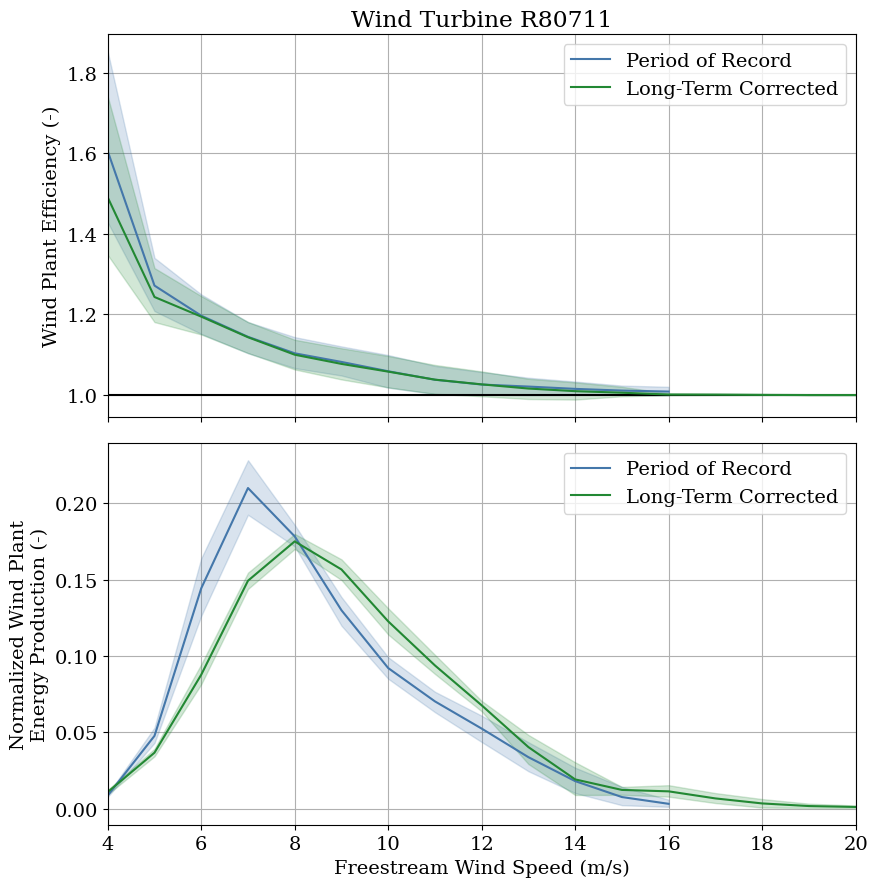

In [28]:
axes = wl.plot_wake_losses_by_wind_speed(turbine_id = "R80711")

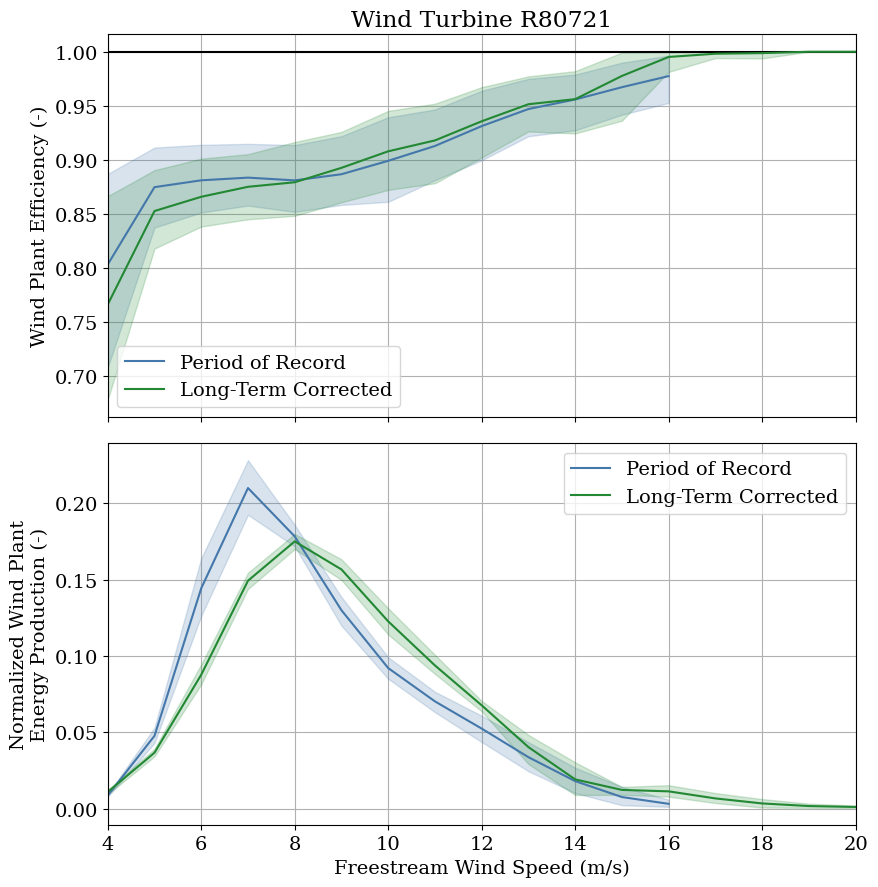

In [29]:
axes = wl.plot_wake_losses_by_wind_speed(turbine_id = "R80721")

As a final point, it is possible that the unrealistic negative wake losses observed for certain wind conditions and wind turbines, as well as the large uncertainty in the estimated wake losses, could be partially explained by the small size of the La Haute Borne wind plant. For example, because there are only four turbines in the wind plant, general underperformance or overperformance for any turbine relative to the others can have an outsized impact on the estimated wake losses for the wind plant, especially for wind directions when only one turbine is classified as a freestream turbine used to estimate the potential wind plant power.

However, even if all turbines exhibit similar performance in response to the same inflow conditions, significant variations in the local wind resource at different turbine locations as a result of terrain, vegetation, wakes from neighboring wind plants, or other influences violate the assumptions of the wake loss estimation method and can lead to unrealistic wake loss estimates. 